--- A2: Perceptron for AND Gate (Step Activation) ---
Final Weights: [0.1  0.05]
Final Bias: -0.10000000000000765
Epochs: 130


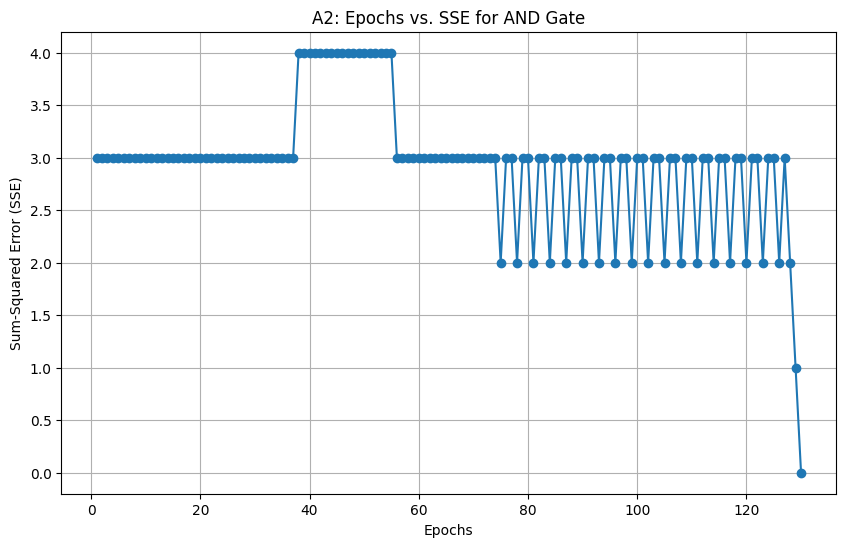


--- A3 & A5: Comparing Activation Functions ---
AND Gate with Bi-Polar Step   -> Epochs: 1000
AND Gate with Sigmoid         -> Epochs: 1000
AND Gate with ReLU            -> Epochs: 390
XOR Gate with Bi-Polar Step   -> Epochs: 1000 (Did not converge)
XOR Gate with Sigmoid         -> Epochs: 1000 (Did not converge)
XOR Gate with ReLU            -> Epochs: 1000 (Did not converge)

--- A4: Varying Learning Rate for AND Gate ---
{0.1: 68, 0.2: 37, 0.3: 23, 0.4: 23, 0.5: 19, 0.6: 19, 0.7: 15, 0.8: 14, 0.9: 13, 1.0: 12}


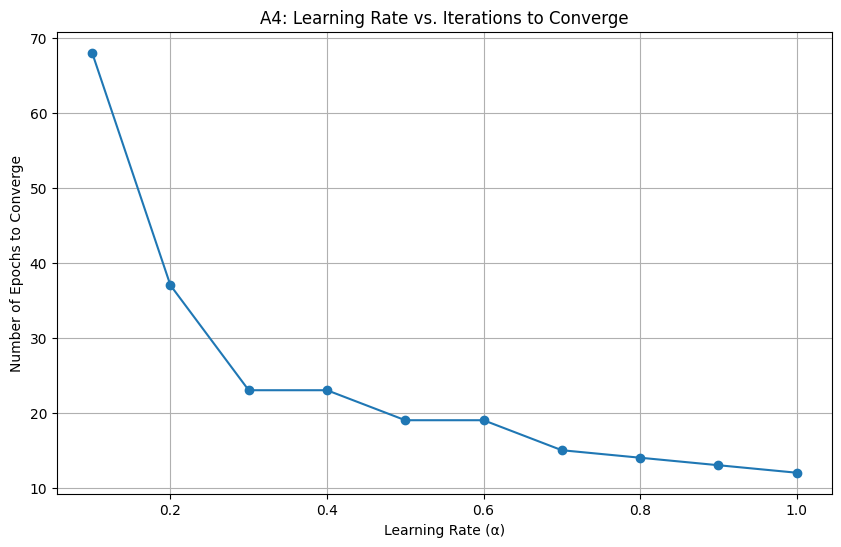


--- A6 & A7: Customer Data ---
A6: Customer perceptron converged in 1000 epochs.
A7: Weights from Pseudo-Inverse: [ 0.1139903  -1.59659696  1.97891087  0.08090146  1.39954053]

--- A8, A9, A10: Backpropagation Neural Network ---
A8: AND Gate (Backprop) converged in 5000 epochs.
A9: XOR Gate (Backprop) converged in 5000 epochs.
A10: AND Gate with 2 outputs (Backprop) converged in 5000 epochs.

--- A11: Scikit-learn MLPClassifier ---
AND Gate (sklearn) converged in 25 iterations.
XOR Gate (sklearn) converged in 18 iterations.

--- A12: MLPClassifier on Your Project Dataset ---
--- Data Analysis ---
Label distribution in the dataset:
label
rest          19674
left           4950
both_feet      4924
both_fists     4905
right          4894
Name: count, dtype: int64
--------------------

--- Model Performance ---
MLP Model successfully trained on '/content/features_filtered.csv'.
MLP Model accuracy on the test set: 50.34%

--- Feature Importance Analysis (from Random Forest) ---
Top 10 most

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)



#summation unit
def summation_unit(inputs, weights, bias):
    return np.dot(inputs, weights) + bias

def step_activation(net_input):
    #step activation function
    return 1 if net_input >= 0 else 0

def bipolar_step_activation(net_input):
    #bipolar Step activation function.
    return 1 if net_input >= 0 else -1

def sigmoid_activation(net_input):
  #sigmoid activation function
    net_input = np.clip(net_input, -500, 500)
    return 1 / (1 + np.exp(-net_input))

def relu_activation(net_input):
    #relu activation function
    return max(0, net_input)

def calculate_sse(errors):
    """A1(c) Calculates the Sum-Squared Error from a list of errors."""
    return np.sum(np.square(errors))

# A2-A7: perceptron training and experiments
def train_perceptron(X, Y, activation_fn, initial_weights, initial_bias, lr, max_epochs, convergence_error):

    #intializing weights.
    weights = np.array(initial_weights)
    #intializing bias
    bias = initial_bias
    #list for appending error
    error_history = []

    for epoch in range(max_epochs):
        # Storing errors for each sample in the current epoch.
        epoch_errors = []
        for i, x_input in enumerate(X):
            # Calculate the net input to the neuron.
            net_input = summation_unit(x_input, weights, bias)
            # appling the activation function to get output
            y_pred = activation_fn(net_input)

            #  Calculating the error (difference between target and prediction).
            error = Y[i] - y_pred
            epoch_errors.append(error)

            #Updating weights and bias based on the error and learning rate.
            weights += lr * error * x_input
            bias += lr * error

        # After processing all samples, calculate the total error for the epoch.
        sse = calculate_sse(epoch_errors)
        error_history.append(sse)

        # Checking for convergence. If error is low enough, stop training.
        if sse <= convergence_error:
            break

    # return the final learned parameters and the history of errors.
    return weights, bias, error_history

def run_perceptron_experiments(X, Y, activations, initial_weights, initial_bias, lr):
    #used to store the number of epoches for required activation function
    results = {}
    for name, func in activations.items():
       #calling the earlier training perceptron
        _, _, errors = train_perceptron(X, Y, func, initial_weights, initial_bias, lr, 1000, 0.002)
        results[name] = len(errors)
    return results

def run_learning_rate_experiment(X, Y, learning_rates, initial_weights, initial_bias):
    epochs_needed = []#storing the epochs count for each learing rate
    #function comapring the different learning rate to see how they affect the number of epoches
    for lr in learning_rates:
        _, _, errors = train_perceptron(X, Y, step_activation, initial_weights, initial_bias, lr, 1000, 0.002)
        epochs_needed.append(len(errors))
    return epochs_needed

def solve_with_pseudo_inverse(X, Y):
    # Adding a column of ones for the bias
    X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
    pseudo_inverse_weights = np.linalg.pinv(X_with_bias).dot(Y)
    return pseudo_inverse_weights


# A8-A10: backpropagation
# two-layer neural network using the backpropagation algorithm.

def sigmoid_derivative(x):
  #sigmoid activation function
    return x * (1.0 - x)

def train_backpropagation_nn(X, Y, n_hidden, lr, max_epochs, convergence_error):
    n_inputs = X.shape[1]
    # determinng  the number of output nodes from the shape of the target matrix Y.
    n_outputs = Y.shape[1] if len(Y.shape) > 1 else 1

    # initializing the weights for both layers with small random numbers.
    V = np.random.uniform(-0.05, 0.05, size=(n_inputs, n_hidden))   # input to hidden weights
    W = np.random.uniform(-0.05, 0.05, size=(n_hidden, n_outputs))  # hidden to output weights
    error_history = []

    for epoch in range(max_epochs):
        # forward pass
        # calculating the  output of the hidden layer.
        hidden_layer_output = sigmoid_activation(np.dot(X, V))
        # calculating output of the final layer.
        predicted_output = sigmoid_activation(np.dot(hidden_layer_output, W))

        # backward pass
        #calculating  the error of the final output.
        error = Y - predicted_output
        sse = np.mean(error**2) # Using Mean Squared Error for stability
        error_history.append(sse)

        #checking for convergence
        if sse <= convergence_error:
            break

        # calculating the gradient (delta) for the output layer.
        delta_output = error * sigmoid_derivative(predicted_output)

        # propagating the error back to the hidden layer.
        error_hidden_layer = delta_output.dot(W.T)
        # calculating the gradient (delta) for the hidden layer.
        delta_hidden = error_hidden_layer * sigmoid_derivative(hidden_layer_output)

        # updating the weights
        # updating the weights connecting the hidden layer to the output layer.
        W += hidden_layer_output.T.dot(delta_output) * lr
        # updating the weights connecting the input layer to the hidden layer.
        V += X.T.dot(delta_hidden) * lr

    return V, W, error_history


# A11-A12:scikit-learn MLP cassifier
# This section wraps the scikit-learn MLPClassifier for comparison and project data.


def train_sklearn_mlp(X, Y, hidden_layers, activation, solver, lr):

    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=activation, solver=solver,
                        learning_rate_init=lr, max_iter=2000, tol=0.002, random_state=1)
    mlp.fit(X, Y)
    return mlp

def run_a12_on_project_data(file_path):
    """
    Loads, preprocesses, trains, and evaluates an MLPClassifier on a custom CSV dataset.
    Also includes diagnostic steps to analyze data and features.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        return f"Error: Dataset file not found at '{file_path}'.", None, None

    # --- DIAGNOSTIC STEP 1: Check Label Distribution ---
    print("--- Data Analysis ---")
    print("Label distribution in the dataset:")
    print(df['label'].value_counts())
    print("-" * 20)

    try:
        feature_columns = df.drop(['label', 'file', 'run'], axis=1, errors='ignore').columns
        X = df[feature_columns].values
        y = df['label'].values
    except KeyError:
        return "Error: Your CSV must contain a 'label' column.", None, None

    # Preprocess the data
    if not np.issubdtype(y.dtype, np.number):
        encoder = LabelEncoder()
        y = encoder.fit_transform(y)

    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the main MLP Classifier
    mlp_model = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=500, random_state=42, activation='relu', solver='adam')
    mlp_model.fit(X_train_scaled, y_train)
    accuracy = mlp_model.score(X_test_scaled, y_test)

    # --- DIAGNOSTIC STEP 2: Check Feature Importance using a Random Forest ---
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    feature_importances = pd.Series(rf_model.feature_importances_, index=feature_columns)

    return accuracy, mlp_model, feature_importances


# plotting function
# These functions handle visualization and are called from the main block.

def plot_epoch_vs_error(errors, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(errors) + 1), errors, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Sum-Squared Error (SSE)')
    plt.grid(True)
    plt.show()

def plot_lr_vs_epochs(learning_rates, epochs_needed, title):
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, epochs_needed, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Learning Rate (α)')
    plt.ylabel('Number of Epochs to Converge')
    plt.grid(True)
    plt.show()

# plotting are initiated from here to keep the functions pure.
if __name__ == "__main__":
    #AND gate
    X_and = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    Y_and = np.array([0, 0, 0, 1])
    #XOR gate
    X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    Y_xor = np.array([0, 1, 1, 0])
    #intialized weights
    initial_weights_A2 = [0.2, -0.75]
    initial_bias_A2 = 10
    #learning rate
    lr_A2 = 0.05
    max_epochs_default = 1000
    convergence_error_default = 0.002

    # A2: Perceptron for AND Gate with Step Activation
    print(" A2: perceptron for AND gate (Step Activation) ")
    #training the perceptron for And Gate
    final_weights_a2, final_bias_a2, errors_a2 = train_perceptron(
        X_and, Y_and, step_activation, initial_weights_A2, initial_bias_A2,
        lr_A2, max_epochs_default, convergence_error_default
    )
    print(f"final Weights: {final_weights_a2}\nfinal Bias: {final_bias_a2}\nepochs: {len(errors_a2)}")
    plot_epoch_vs_error(errors_a2, 'A2: epochs vs. SSE for AND Gate')

    # A3 & A5: comparing Activation Function
    print("\nA3 & A5: comparing Activation Functions")
    #testing the perceptron for And gate
    activation_functions = {"Bi-Polar Step": bipolar_step_activation, "Sigmoid": sigmoid_activation, "ReLU": relu_activation}
    a3_results = run_perceptron_experiments(X_and, Y_and, activation_functions, initial_weights_A2, initial_bias_A2, lr_A2)
    for name, epochs in a3_results.items():
        print(f"AND Gate with {name:<15} -> Epochs: {epochs}")
     #testing the perceptron for Xor gate
    a5_results = run_perceptron_experiments(X_xor, Y_xor, activation_functions, initial_weights_A2, initial_bias_A2, lr_A2)
    for name, epochs in a5_results.items():
        status = "(Did not converge)" if epochs >= max_epochs_default else ""
        print(f"XOR Gate with {name:<15} -> Epochs: {epochs} {status}")

    #  A4: varying Learning Rate
    print("\nA4: Varying Learning Rate for AND Gate")
    learning_rates_a4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #training And gate with different learning rate
    epochs_needed_a4 = run_learning_rate_experiment(X_and, Y_and, learning_rates_a4, initial_weights_A2, initial_bias_A2)
    print(dict(zip(learning_rates_a4, epochs_needed_a4)))
    plot_lr_vs_epochs(learning_rates_a4, epochs_needed_a4, 'A4: Learning Rate vs. Iterations to Converge')

    #A6 & A7: given the table
    print("\nA6 & A7: Customer Data ")
    X_cust = np.array([[20,6,2,386], [16,3,6,289], [27,6,2,393], [19,1,2,110], [24,4,2,280], [22,1,5,167], [15,4,2,271], [18,4,2,274], [21,1,4,148], [16,2,4,198]])
    Y_cust = np.array([1,1,1,0,1,0,1,1,0,0])
    X_cust_norm = X_cust / np.linalg.norm(X_cust, axis=0)
    #trainging the perceptron with sigmoid activation on custom dataset
    _, _, errors_a6 = train_perceptron(X_cust_norm, Y_cust, sigmoid_activation, np.random.rand(4), np.random.rand(1), 0.1, max_epochs_default, convergence_error_default)
    print(f"A6: Customer perceptron converged in {len(errors_a6)} epochs.")
    pseudo_weights_a7 = solve_with_pseudo_inverse(X_cust_norm, Y_cust)
    print(f"A7: Weights from Pseudo-Inverse: {pseudo_weights_a7}")

    #A8, A9, A10: Backpropagation Neural Network
    print("\nA8, A9, A10: Backpropagation Neural Network ")
    #neural network solves Xor where perceptron could n't
    _, _, errors_a8 = train_backpropagation_nn(X_and, np.array([[0],[0],[0],[1]]), 2, 0.05, 5000, 0.002)
    print(f"A8: AND Gate (Backprop) converged in {len(errors_a8)} epochs.")
    _, _, errors_a9 = train_backpropagation_nn(X_xor, np.array([[0],[1],[1],[0]]), 2, 0.05, 5000, 0.002)
    print(f"A9: XOR Gate (Backprop) converged in {len(errors_a9)} epochs.")
    _, _, errors_a10 = train_backpropagation_nn(X_and, np.array([[1,0],[1,0],[1,0],[0,1]]), 2, 0.05, 5000, 0.002)
    print(f"A10: AND Gate with 2 outputs (Backprop) converged in {len(errors_a10)} epochs.")

    #  A11: Scikit-learn MLPClassifier
    print("\nA11: Scikit-learn MLPClassifier")
    #mlp classifier for AND gate
    mlp_model_and = train_sklearn_mlp(X_and, Y_and, (2,), 'logistic', 'sgd', 0.05)
    print(f"AND Gate (sklearn) converged in {mlp_model_and.n_iter_} iterations.")
    mlp_model_xor = train_sklearn_mlp(X_xor, Y_xor, (2,), 'logistic', 'sgd', 0.05)
    print(f"XOR Gate (sklearn) converged in {mlp_model_xor.n_iter_} iterations.")

    # A12: MLPClassifier on Project Dataset with Diagnostics
    print("\nA12: MLPClassifier on Your Project Dataset")
    project_file_path = '/content/features_filtered.csv'
    a12_result, a12_model, a12_importances = run_a12_on_project_data(project_file_path)

    if a12_model is None:
        print(a12_result) # This will print the error message from the function.
    else:
        print("\n--- Model Performance ---")
        print(f"MLP Model successfully trained on '{project_file_path}'.")
        print(f"MLP Model accuracy on the test set: {a12_result:.2%}")
        print("\n--- Feature Importance Analysis (from Random Forest) ---")
        print("Top 10 most predictive features:")
        print(a12_importances.nlargest(10))